# Artificial Neural Networks and Deep Learning

---

## ⚙️ Import Libraries

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
import random
from matplotlib import pyplot as plt
import pandas as pd

import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from PIL import Image
import matplotlib.gridspec as gridspec

import os
os.listdir('/kaggle/input/')

seed = 36
np.random.seed(seed)
tf.random.set_seed(seed);

## ⏳ Load and inspect the data

In [2]:
data = np.load('/kaggle/input/training_set.npz')
X = data['images']
y = data['labels']

print('Before data points filter shape:', X.shape, y.shape)
import json
with open('/kaggle/input/blacklist.json', 'r') as file:
	blacklist = json.load(file)
blacklist = sorted(blacklist['blacklist'])
X = np.delete(X, blacklist, axis=0)
y = np.delete(y, blacklist, axis=0)

print('After data points filter shape:', X.shape, y.shape)

# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

# Normalize
X = (X/255).astype('float32')

# Convert to one hoot encoding
y = tfk.utils.to_categorical(y)

# Labels
labels = {
	0: "Basophil",
	1: "Eosinophil",
	2: "Erythroblast",
	3: "Immature granulocytes",
	4: "Lymphocyte",
	5: "Monocyte",
	6: "Neutrophil",
	7: "Platelet"
}

train_size = int(X.shape[0] * 0.8)
val_size = int(X.shape[0] * 0.1)
test_size = X.shape[0] - train_size - val_size

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=val_size, stratify=y_train)

print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Before data points filter shape: (13759, 96, 96, 3) (13759, 1)
After data points filter shape: (11959, 96, 96, 3) (11959, 1)
Counting occurrences of target classes:
digit
6    2330
1    2181
3    2026
7    1643
2    1085
5     993
0     852
4     849
Name: count, dtype: int64
Training Data Shape: (9567, 96, 96, 3)
Training Label Shape: (9567, 8)
Validation Data Shape: (1195, 96, 96, 3)
Validation Label Shape: (1195, 8)


/tmp/ipykernel_30/660508516.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return labels[int(index)]


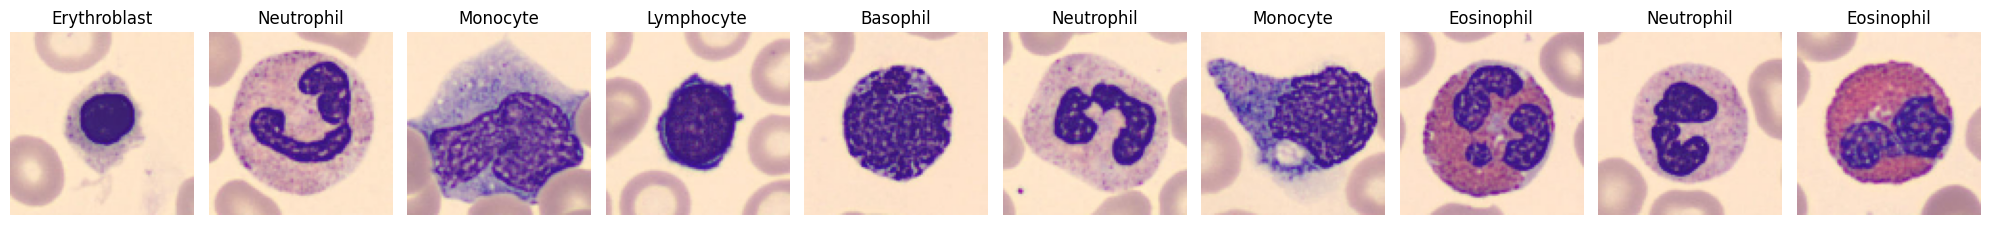

In [3]:
# Inspect data
# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X_val)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

def get_label(y):
    index = np.where(y == 1)[0]
    return labels[int(index)]

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_val[idx]), vmin=0., vmax=1.)
    ax.set_title(get_label(y_val[idx]))
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

## 🛠️ Train and Save the Model

In [4]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]
learning_rate = 0.001
dropout_rate=0.3
l2_lambda=0.01

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [5]:
#modello 5: paper 4
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    dropout_rate=dropout_rate,
    l2_lambda=l2_lambda,
    augmentation=None,
    seed=seed
):
    tf.random.set_seed(seed)

    # Initialise weights and regulariser
    initialiser = tfk.initializers.GlorotNormal(seed=seed)
    regulariser = tfk.regularizers.l2(l2_lambda)

    inputs = tfkl.Input(shape=input_shape, name='Input')
    
    # Apply optional data augmentation, then first convolutional layer
    if augmentation == None:
        x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', kernel_regularizer=regulariser, name='conv1')(inputs)
    else:
        x = augmentation(inputs)
        x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', kernel_regularizer=regulariser, name='conv1')(x)

    x = tfkl.Activation('relu', name='act1')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed, name='Dropout1')(x)

    #layer 2
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', kernel_regularizer=regulariser, name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)
    x = tfkl.Activation('relu', name='act2')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed, name='Dropout2')(x)

    #layer 3
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', kernel_regularizer=regulariser, name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)
    x = tfkl.Activation('relu', name='act3')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp3')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed, name='Dropout3')(x)
    
    #skip connection
    skip = tfkl.Conv2D(filters=256, kernel_size=1, padding='same', name='skip_conv')(x)
    skip = tfkl.BatchNormalization(name='bn_skip')(skip)
    skip = tfkl.MaxPooling2D(pool_size=8, name='skip_pooling')(skip) 
    
    #layer 4
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', kernel_regularizer=regulariser, name='conv4')(x)
    x = tfkl.BatchNormalization(name='bn4')(x)
    x = tfkl.Activation('relu', name='act4')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp4')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed, name='Dropout4')(x)

    #layer 5
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=regulariser, name='conv5')(x)
    x = tfkl.BatchNormalization(name='bn5')(x)
    x = tfkl.Activation('relu', name='act5')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp5')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed, name='Dropout5')(x)

    #layer 6
    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=regulariser, name='conv6')(x)
    x = tfkl.BatchNormalization(name='bn6')(x)
    x = tfkl.Activation('relu', name='act6')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp6')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed, name='Dropout6')(x)
    
    x = tfkl.Add(name='add')([x, skip]) 
    
    #solo per tenermi le funzioni
    #x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    # Fully connected layers
    x = tfkl.Flatten(name='flatten')(x)

    x = tfkl.Dense(units=128, name='dense1')(x)
    x = tfkl.Activation('relu', name='act7')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed, name='Dropout7')(x)
    
    x = tfkl.Dense(units=output_shape, name='dense2')(x)
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [14]:
#model acc = 0.24 (with augmentation = None)

def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    dropout_rate=0.45,
    l2_lambda=0,
    augmentation=None,
    seed=seed
):
    tf.random.set_seed(seed)

     # Initialise weights and regulariser
    initialiser = tfk.initializers.GlorotNormal(seed=seed)
    regulariser = tfk.regularizers.l2(l2_lambda)
    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    if augmentation == None:
        x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', kernel_regularizer=regulariser, name='conv1')(inputs) #with same you have padding with the same size as input
    else:
        x = augmentation(inputs)
        x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', kernel_regularizer=regulariser, name='conv1')(x) #with same you have padding with the same size as input
    x = tfkl.Activation('relu', name='act1')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)


    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', kernel_regularizer=regulariser, name='conv2')(x) #with same you have padding with the same size as input
    x = tfkl.Activation('relu', name='act2')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=regulariser, name='conv3')(x)
    x = tfkl.Activation('relu', name='act3')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp3')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=regulariser, name='conv4')(x) #with same you have padding with the same size as input
    x = tfkl.Activation('relu', name='act4')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp4')(x)

    x = tfkl.Dropout(dropout_rate, seed=seed, name='Dropout1')(x)
    x = tfkl.GlobalAveragePooling2D(name='global_avg_pool')(x)

    x = tfkl.Dense(128,activation='relu', name='dense1')(x) #128 for computation
    x = tfkl.Dense(units=output_shape, name='dense')(x)

    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')



    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1 (Conv2D)              │ (None, 96, 96, 32)    │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act1 (Activation)           │ (None, 96, 96, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp1 (MaxPooling2D)          │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2 (Conv2D)              │ (None, 48, 48, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act2 (Activation)           │ (None, 48, 48, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp2 (MaxPooling2D)          │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv3 (Conv2D)              │ (None, 24, 24, 128)   │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act3 (Activation)           │ (None, 24, 24, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp3 (MaxPooling2D)          │ (None, 12, 12, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv4 (Conv2D)              │ (None, 12, 12, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act4 (Activation)           │ (None, 12, 12, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp4 (MaxPooling2D)          │ (None, 6, 6, 256)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dropout1 (Dropout)          │ (None, 6, 6, 256)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_avg_pool             │ (None, 256)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense1 (Dense)              │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 8)             │      1,032 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ softmax (Activation)        │ (None, 8)             │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 422,344 (1.61 MB)

 Trainable params: 422,344 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

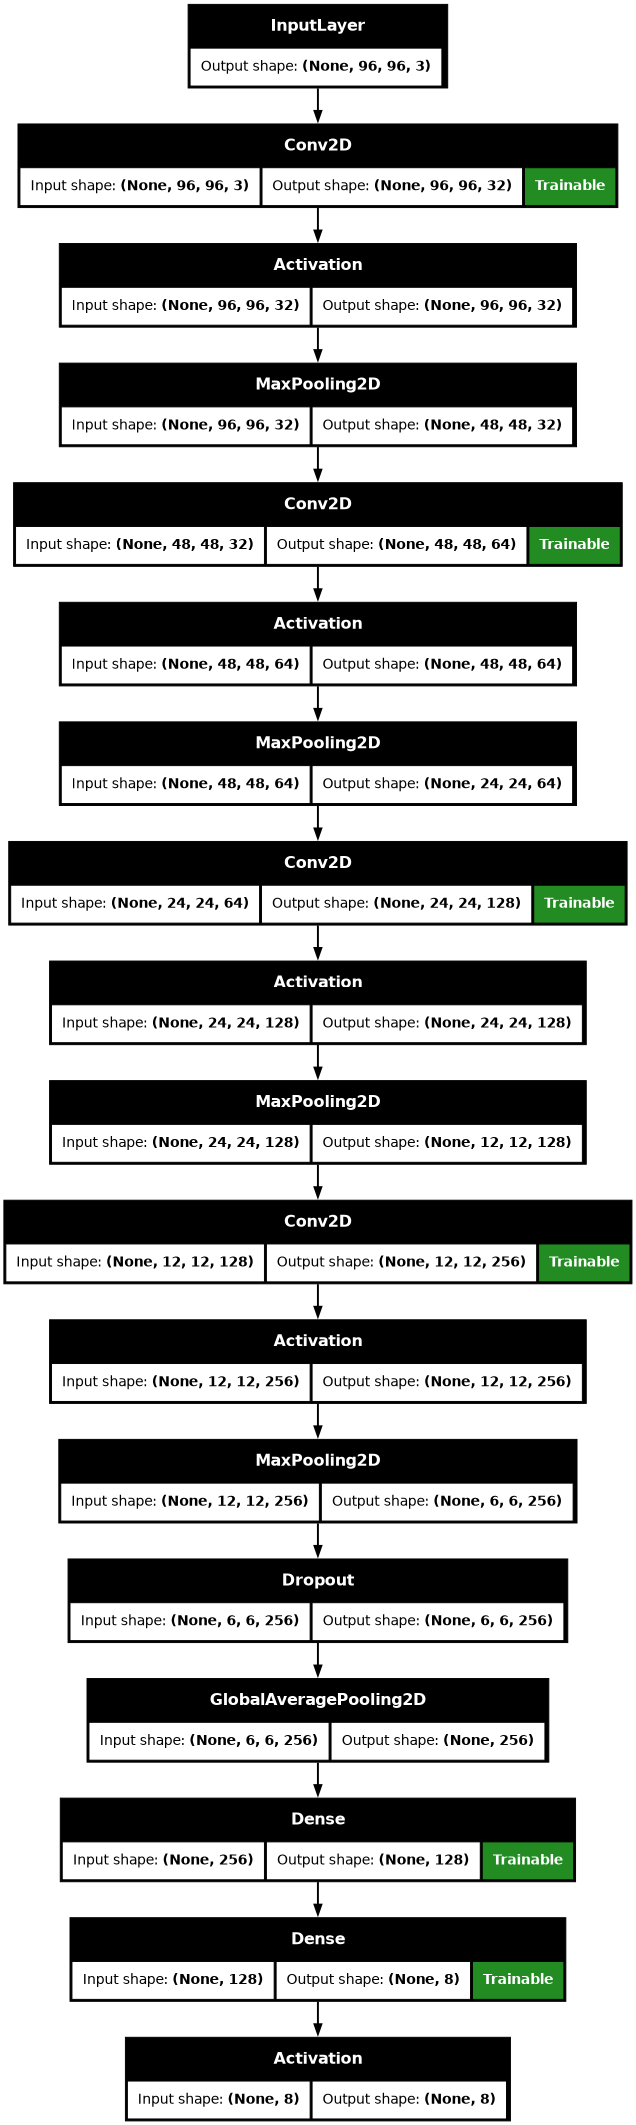

In [15]:
# Define a data augmentation pipeline
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomBrightness(0.2, value_range=(0,1)),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomZoom(0.2),
    tfkl.RandomContrast(0.75),
], name='preprocessing')

# Build the model
model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [8]:
# Define the patience value for early stopping
patience = 30

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [ ]:
epochs = 1000
batch_size = 128

# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'BloodCells5_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Load the saved model
model = tfk.models.load_model('BloodCells5_76.49.keras')

# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ✍🏿 Make evaluation

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print('Model, accuracy: {:5.2f}%'.format(100 * acc))

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('BloodCells5_76.49.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py BloodCells5_76.49.keras

from IPython.display import FileLink

# Display a link to download the file
FileLink(filename)